# SETUP

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model,clone_model

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 220 (delta 37), reused 17 (delta 17), pack-reused 178
Receiving objects: 100% (220/220), 83.78 MiB | 45.83 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [23]:
## datapaths setup

clean_val_path = "/content/drive/MyDrive/data/Lab3/cl/valid.h5"
clean_test_path = "/content/drive/MyDrive/data/Lab3/cl/test.h5"
bad_val_path = "/content/drive/MyDrive/data/Lab3/bd/bd_valid.h5"
bad_test_path = "/content/drive/MyDrive/data/Lab3/bd/bd_test.h5"


# Let us retrieve the dataset stored in h5 form
def data_loader(path):
    data = h5py.File(path)
    X = np.array(data["data"])
    X = X.transpose((0,2,3,1))
    Y = np.array(data["label"])

    return X,Y

clean_val,clean_val_lab = data_loader(clean_val_path)
clean_test,clean_test_lab = data_loader(clean_test_path)
bad_val,bad_val_lab = data_loader(bad_val_path)
bad_test,bad_test_lab = data_loader(bad_test_path)

# Model

In [5]:
# Let us load the given Badnet
Badnet_path = "/content/CSAW-HackML-2020/lab3/models/bd_net.h5"
Badnet_weights_path = "/content/CSAW-HackML-2020/lab3/models/bd_weights.h5"
Badnet = load_model(Badnet_path)
Badnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [48]:
from sklearn.metrics import accuracy_score
# Let us calculate the original accuracy of the Badnet

def get_accuracy(model, data, labels):
    predictions = model.predict(data,verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == labels)
    return accuracy*100


# Pruning the model

In [7]:
layer0 = Badnet.layers[0](clean_val)
layer1 = Badnet.layers[1](tf.cast(layer0, tf.float32))
layer2 = Badnet.layers[2](tf.cast(layer1, tf.float32))
layer3 = Badnet.layers[3](tf.cast(layer2, tf.float32))
layer4 = Badnet.layers[4](tf.cast(layer3, tf.float32))
layer5 = Badnet.layers[5](tf.cast(layer4, tf.float32))
layer6 = Badnet.layers[6](tf.cast(layer5, tf.float32))
op_val = np.array(layer6)
avg_val = np.mean(op_val, axis=(0,1,2))

# Sort ny activation
sorted_channels = np.argsort(avg_val)
print(sorted_channels)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


In [8]:
def reset_clone():
  clone_thresh = clone_model(Badnet)
  clone_thresh.set_weights(Badnet.get_weights())
  pool_layer_weights = clone_thresh.get_layer("conv_3").get_weights()
  weights = pool_layer_weights[0]
  bias = pool_layer_weights[1]
  return clone_thresh, weights, bias

In [9]:
acc_after_prune = {}
attack_success_after_prune = {}
threshmodels = {}

original_accuracy = get_accuracy(Badnet,clean_val,clean_val_lab)



clone_thresh, weights, bias = reset_clone()
threshes = [2,4,10]
t = 0
for i,channel in enumerate(sorted_channels):
    print("Channels pruned : "+str(i+1)+"/"+str(60))
    # prune channel

    weights[:, :, :, channel] = 0
    bias[channel] = 0
    clone_thresh.get_layer("conv_3").set_weights([weights,bias])

    # Calculate accuracy
    pruned_accuracy = get_accuracy(clone_thresh, clean_val, clean_val_lab)
    acc_after_prune[channel] = pruned_accuracy
    change_in_acc = original_accuracy - pruned_accuracy
    print('----------------------------------------------------------------')
    print(f'Threshold of {threshes[t]} %')
    print(f"Channels pruned : {i}/60")
    print(f"Pruning channel index now: {channel}")
    print(f"Pruned accuracy : {pruned_accuracy}")
    print(f"Change in accuracy : {(original_accuracy - pruned_accuracy)}")

    # Check if the accuracy drop is beyond the threshold
    if t<len(threshes) and change_in_acc >= threshes[t]:
        clone_thresh.save(f'{threshes[t]}_percent_model.h5')
        threshmodels[threshes[t]] = clone_thresh
        t+=1
    if t == len(threshes):
      break







Channels pruned : 1/60
----------------------------------------------------------------
Threshold of 2 %
Channels pruned : 0/60
Pruning channel index now: 0
Pruned accuracy : 98.64899974019225
Change in accuracy : 0.0
Channels pruned : 2/60
----------------------------------------------------------------
Threshold of 2 %
Channels pruned : 1/60
Pruning channel index now: 26
Pruned accuracy : 98.64899974019225
Change in accuracy : 0.0
Channels pruned : 3/60
----------------------------------------------------------------
Threshold of 2 %
Channels pruned : 2/60
Pruning channel index now: 27
Pruned accuracy : 98.64899974019225
Change in accuracy : 0.0
Channels pruned : 4/60
----------------------------------------------------------------
Threshold of 2 %
Channels pruned : 3/60
Pruning channel index now: 30
Pruned accuracy : 98.64899974019225
Change in accuracy : 0.0
Channels pruned : 5/60
----------------------------------------------------------------
Threshold of 2 %
Channels pruned : 4/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


----------------------------------------------------------------
Threshold of 2 %
Channels pruned : 44/60
Pruning channel index now: 29
Pruned accuracy : 95.75647354291158
Change in accuracy : 2.8925261972806737
Channels pruned : 46/60
----------------------------------------------------------------
Threshold of 4 %
Channels pruned : 45/60
Pruning channel index now: 16
Pruned accuracy : 95.20221702606739
Change in accuracy : 3.446782714124865
Channels pruned : 47/60
----------------------------------------------------------------
Threshold of 4 %
Channels pruned : 46/60
Pruning channel index now: 56
Pruned accuracy : 94.7172425738287
Change in accuracy : 3.9317571663635533
Channels pruned : 48/60


----------------------------------------------------------------
Threshold of 4 %
Channels pruned : 47/60
Pruning channel index now: 46
Pruned accuracy : 92.09318437689443
Change in accuracy : 6.555815363297825
Channels pruned : 49/60
----------------------------------------------------------------
Threshold of 10 %
Channels pruned : 48/60
Pruning channel index now: 5
Pruned accuracy : 91.49562656967177
Change in accuracy : 7.1533731705204815
Channels pruned : 50/60
----------------------------------------------------------------
Threshold of 10 %
Channels pruned : 49/60
Pruning channel index now: 8
Pruned accuracy : 91.01931237550879
Change in accuracy : 7.629687364683463
Channels pruned : 51/60
----------------------------------------------------------------
Threshold of 10 %
Channels pruned : 50/60
Pruning channel index now: 11
Pruned accuracy : 89.17467740538669
Change in accuracy : 9.474322334805564
Channels pruned : 52/60


----------------------------------------------------------------
Threshold of 10 %
Channels pruned : 51/60
Pruning channel index now: 54
Pruned accuracy : 84.43751623798389
Change in accuracy : 14.211483502208367


# Logging

In [10]:
# Let us evaluate our different B' models

#Load models
mod_2 = load_model('/content/2_percent_model.h5')
mod_4 = load_model('/content/4_percent_model.h5')
mod_10 = load_model('/content/10_percent_model.h5')

## Evaluate on the eval.py

In [14]:
# 2%
model_filename = "/content/2_percent_model.h5"

%run eval.py $clean_test_path $bad_test_path $model_filename


401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
Attack Success Rate: 100.0


In [15]:
# 4%

model_filename = "/content/4_percent_model.h5"

%run eval.py $clean_test_path $bad_test_path $model_filename

401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
Attack Success Rate: 99.98441153546376


In [16]:
# 10%

model_filename = "/content/10_percent_model.h5"

%run eval.py $clean_test_path $bad_test_path $model_filename

401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
Attack Success Rate: 77.20966484801247


# Grouping the models together

In [50]:
import tensorflow as tf
from tensorflow import keras

class GNet(keras.Model):
    def __init__(self, B, B1, n=1283):
        super(GNet, self).__init__()
        self.B = B
        self.B1 = B1
        self.n = n

    def call(self, data):
        y = tf.argmax(self.B(data), axis=1, output_type=tf.int32)
        y1 = tf.argmax(self.B1(data), axis=1, output_type=tf.int32)
        default_class = tf.constant(self.n, dtype=tf.int32)
        predictions = tf.where(tf.equal(y, y1), y, tf.fill(tf.shape(y), default_class))
        return predictions


In [53]:
G2 = GNet(B=Badnet, B1=mod_2, n=1283)
G4 = GNet(B=Badnet, B1=mod_4, n=1283)
G10 = GNet(B=Badnet, B1=mod_10, n=1283)

In [54]:
def print_rates(model,n):
  p1 = model.predict(clean_test)
  acc = np.mean(np.equal(p1, clean_test_lab))*100
  p2 = model.predict(bad_test)
  attack_success_rate = np.mean(np.equal(p2,bad_test_lab))*100

  print(f'Model {n}% : accuracy: {acc} : attack_success_rate: {attack_success_rate}')

print_rates(G2,2)
print_rates(G4,4)
print_rates(G10,10)

401/401 [==============================] - 1s 3ms/step
Model 2% : accuracy: 95.74434918160561 : attack_success_rate: 100.0
401/401 [==============================] - 1s 3ms/step
Model 4% : accuracy: 92.1278254091972 : attack_success_rate: 99.98441153546376
401/401 [==============================] - 1s 3ms/step
Model 10% : accuracy: 84.3335931410756 : attack_success_rate: 77.20966484801247


# Plot acc vs channels pruned

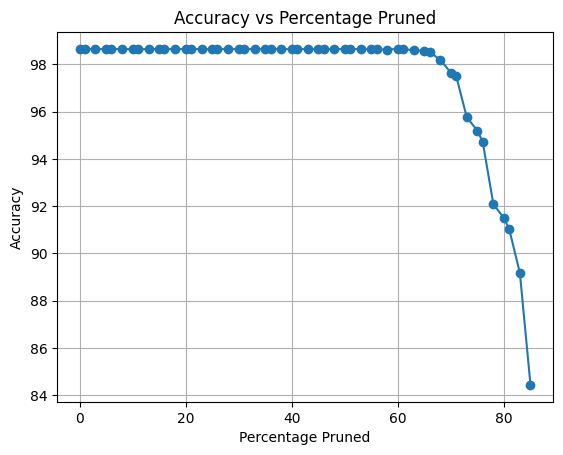

In [59]:
acc_after_prune

list_acc = []
percentage_pruned = []
for num,i in enumerate(sorted_channels):
  if i in acc_after_prune.keys():
    list_acc.append(acc_after_prune[i])
    percentage_pruned.append(int(num/60*100))


import matplotlib.pyplot as plt


plt.plot(percentage_pruned,list_acc, marker='o', linestyle='-')
plt.title('Accuracy vs Percentage Pruned')
plt.xlabel('Percentage Pruned')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


